In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import argparse
import numpy as np
from run_vmc import main

def check_info(step, log, driver, save_path):
    if not isinstance(driver.info, dict):
        status = int(driver.info)
        if status != 0:
            print(f"Solver returned error status: {status}")
            np.save(save_path + "error_local_energies.npy", driver.state.local_estimators(driver._ham))
            print("Local energies saved...")
            return False
        else:
            return True
    return True


def get_data(args):
    logger = main(args, return_logger=True)
    if logger.restore():
        return logger
    else:
        raise FileNotFoundError("No logger found")

Single node computation
[CudaDevice(id=0)]


/mnt/home/rwiersema/netket_jaxmg/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


∣NK⟩ Tip: You can disable these tips by setting export NETKET_NO_TIPS=1 in your .bashrc.

Making path in process 0


/mnt/home/rwiersema/netket_jaxmg/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/home/rwiersema/netket_jaxmg/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


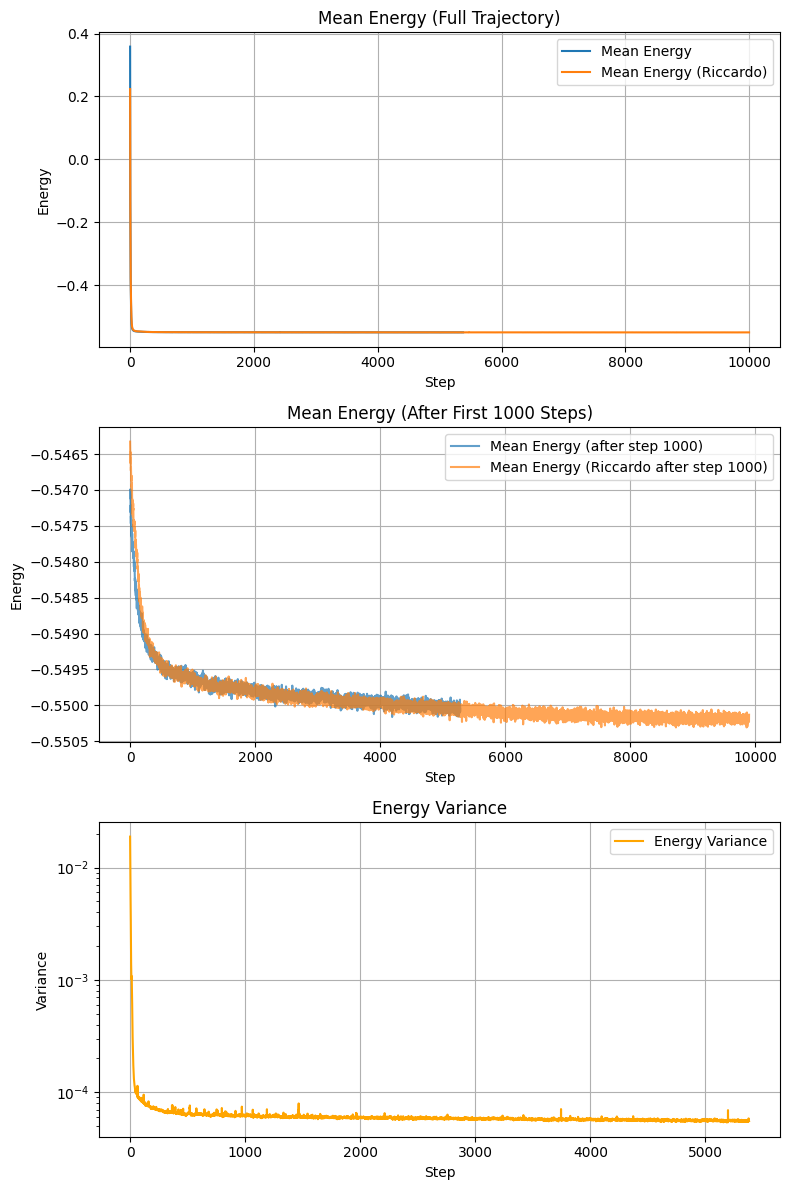

In [3]:
# Configuration dictionary
config = {
    "ns": 2**14,  # Number of samples
    "patch_size": 3,  # Effective patch size
    "num_layers": 2,  # Number of layers
    "d_model": 72,  # Model hidden vector size
    "heads": 12,  # Number of MHA heads
    "L": 12,  # Lattice size of 2D lattice
    "chunk_size": 2**12,  # Jacobian chunk size NTK
    "seed": 100,  # Seed
    "experiment_name" :"Feb10"
}

# Convert to namespace for compatibility with get_data
args = argparse.Namespace(**config)
logger = get_data(args)

# Extract energy data
L = config["L"]
N=L**2
energies_mean = np.array(logger.data["Energy"]["Mean"]) / (N *4)
energies_variance = np.array(logger.data["Energy"]["Variance"]) / (N * 4)**2

# Create figure with 3 subplots
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(8, 12)

# Plot 1: Mean energy (full trajectory)
# Load loss data from loss.txt
energies_mean_riccardo = np.loadtxt('loss.txt')
axs[0].plot(energies_mean, label="Mean Energy")
axs[0].plot(energies_mean_riccardo, label="Mean Energy (Riccardo)")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Energy")
axs[0].set_title("Mean Energy (Full Trajectory)")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Mean energy after first 1000 steps
axs[1].plot(energies_mean[100:], label="Mean Energy (after step 1000)", alpha=0.7)
axs[1].plot(energies_mean_riccardo[100:], label="Mean Energy (Riccardo after step 1000)", alpha=0.7)
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Energy")
axs[1].set_title("Mean Energy (After First 1000 Steps)")
axs[1].legend()
axs[1].grid(True)

# Plot 3: Variance of energy
axs[2].plot(energies_variance, label="Energy Variance", color="orange")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Variance")
axs[2].set_title("Energy Variance")
axs[2].legend()
axs[2].set_yscale("log")
axs[2].grid(True)

plt.tight_layout()
plt.show()